In [1]:
import numpy as np
from keras.layers import Input, Dense, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, Activation
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers

import keras.backend as K
K.set_image_data_format('channels_last')

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt

# load data

In [3]:
data = np.genfromtxt('../input/train.csv', delimiter=",")
data.shape

(42001, 785)

In [4]:
# scale pixels values, by /255
X = data[1:, 1:].reshape((-1, 28, 28, 1))
X /= 255

X.shape

(42000, 28, 28, 1)

In [5]:
# add one hot encoding
y = data[1:, 0]

# delete data variable, to make space
del data

# binarize the labels
lb = LabelBinarizer()
y = lb.fit_transform(y)

y.shape, y

((42000, 10), array([[0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]]))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

In [7]:
# function for defining model
def recogModel(input_shape):
    # 28x28
    X_input = Input(input_shape)

    X = Conv2D(6, (5,5), strides=(1,1), kernel_regularizer=regularizers.l2(0.01), name='conv0')(X_input)
    # batch normalization?
    # can accelerate training
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    # 24x24x6
    X = MaxPooling2D((2,2), strides=(2,2), name='maxPool0')(X)

    # 12x12x6
    X = Conv2D(16, (5,5), strides=(1,1), kernel_regularizer=regularizers.l2(0.01), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)

    # 8x8x16
    X = MaxPooling2D((2,2), strides=(2,2), name='maxPool1')(X)

    # 4x4x16
    X = Flatten()(X)
    # 256
    X = Dense(120, activation='relu', name='fc2')(X)
    # adding dropout to curb overfitting
    #X = Dropout(0.2)(X)
    # 120
    X = Dense(84, activation='relu', name='fc3')(X)
    #X = Dropout(0.2)(X)
    # 84
    X = Dense(10, activation='softmax', name='fc4')(X)

    model = Model(inputs=X_input, outputs=X, name='model')

    return model

In [8]:
# function for defining different model
def newModel(input_shape):
    # 28x28
    X_input = Input(input_shape)

    X = Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu')(X_input)
    X = Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu')(X)
    X = MaxPooling2D(pool_size=(2,2))(X)
    X = Dropout(0.25)(X)

    X = Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu')(X)
    X = Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu')(X)
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2))(X)
    X = Dropout(0.25)(X)

    X = Flatten()(X)
    X = Dense(256, activation = "relu")(X)
    X = Dropout(0.5)(X)
    X = Dense(10, activation = "softmax")(X)

    model = Model(inputs=X_input, outputs=X, name='newModel')

    return model

In [9]:
# function for defining a bigger model
def bigModel(input_shape):
    # 28x28
    X_input = Input(input_shape)

    X = Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu')(X_input)
    X = Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu')(X)
    X = MaxPooling2D(pool_size=(2,2))(X)
    X = Dropout(0.25)(X)

    X = Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu')(X)
    X = Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu')(X)
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2))(X)
    X = Dropout(0.25)(X)
    
    X = Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu')(X)
    X = Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu')(X)
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2))(X)
    X = Dropout(0.25)(X)

    X = Flatten()(X)
    X = Dense(512, activation = "relu")(X)
    X = Dropout(0.5)(X)
    X = Dense(128, activation = "relu")(X)
    X = Dropout(0.5)(X)
    X = Dense(10, activation = "softmax")(X)

    model = Model(inputs=X_input, outputs=X, name='newModel')

    return model

In [10]:
# callback for setting learning rate, after stagnation in val_loss
# if no change in val_loss for 3 epochs it will reduce the learning rate to half
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.0)

In [11]:
X_train.shape[1:]

(28, 28, 1)

In [12]:
# Create model by calling above function
#model = recogModel(X_train.shape[1:])
model = newModel(X_train.shape[1:])

In [13]:
# Compile the model
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['accuracy'])

In [14]:
# Train the model on train data
#model.fit(x=X_train, y=y_train, epochs=1, batch_size=50)
#model.save('recogModel.h5')
# using data augmentation instead

In [15]:
# data augmentation to prevent overfitting
data_aug = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1)

# Fit the model
model_history = model.fit_generator(data_aug.flow(X_train, y_train, batch_size=50), epochs = 5, validation_data = (X_test,y_test),
                              steps_per_epoch=X_train.shape[0] / 30, callbacks=[learning_rate_reduction])

Epoch 1/5
1260/1260 [==============================] - 33s 26ms/step - loss: 0.0138 - acc: 0.9036 - val_loss: 0.0027 - val_acc: 0.9829
Epoch 2/5
1260/1260 [==============================] - 27s 21ms/step - loss: 0.0052 - acc: 0.9662 - val_loss: 0.0023 - val_acc: 0.9867
Epoch 3/5
1260/1260 [==============================] - 26s 21ms/step - loss: 0.0041 - acc: 0.9738 - val_loss: 0.0017 - val_acc: 0.9890
Epoch 4/5
1260/1260 [==============================] - 27s 21ms/step - loss: 0.0036 - acc: 0.9773 - val_loss: 0.0017 - val_acc: 0.9888
Epoch 5/5
1260/1260 [==============================] - 27s 21ms/step - loss: 0.0032 - acc: 0.9797 - val_loss: 0.0020 - val_acc: 0.9876


In [16]:
# model = keras.models.load_model('my_model.h5')
# Test the model on test data
preds = model.evaluate(X_test, y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4200/4200 [==============================] - 1s 122us/step

Loss = 0.0020004416583815983
Test Accuracy = 0.9876190476190476


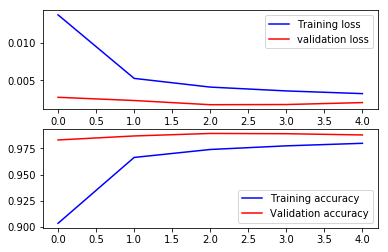

In [17]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(model_history.history['loss'], color='b', label="Training loss")
ax[0].plot(model_history.history['val_loss'], color='r', label="validation loss")
ax[0].legend()

ax[1].plot(model_history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(model_history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].legend()

## predict for the test.csv

In [18]:
test = np.genfromtxt('../input/test.csv', delimiter=",")
test.shape

(28001, 784)

In [19]:
# scale pixels values, by /255
testX = test[1:, :].reshape((-1, 28, 28, 1))
testX /= 255

# delete test variable, to make space
del test

testX.shape

(28000, 28, 28, 1)

In [20]:
# predict the values
preds = model.predict(testX)
preds.shape, preds

((28000, 10),
 array([[2.5271115e-25, 3.0151165e-21, 1.0000000e+00, ..., 8.1372609e-17,
         2.6607422e-19, 3.7984349e-26],
        [1.0000000e+00, 1.0685857e-18, 1.3035807e-13, ..., 2.4648160e-18,
         8.8053219e-18, 2.5590383e-13],
        [3.3011430e-12, 3.1073299e-12, 1.3533401e-12, ..., 5.0758125e-08,
         1.3599204e-08, 1.0000000e+00],
        ...,
        [1.9325299e-20, 3.2948250e-21, 2.3121967e-18, ..., 1.3648633e-15,
         3.6439904e-15, 1.3538170e-13],
        [4.5182161e-10, 2.6713527e-11, 1.2638037e-11, ..., 2.0185000e-05,
         2.4675564e-10, 9.9997985e-01],
        [6.4201575e-32, 1.4662382e-26, 1.0000000e+00, ..., 5.2286049e-22,
         2.1151449e-21, 1.5683537e-32]], dtype=float32))

In [21]:
# turn 10 nos. to single index, predicted digit
predictions = np.argmax(preds, axis=1)
predictions.shape, predictions

((28000,), array([2, 0, 9, ..., 3, 9, 2]))

In [22]:
# save the predictions in a csv file
import pandas as pd 

# numpy array to panda's DataFrame
df = pd.DataFrame(predictions, columns=['Label'])

# add index to the dataframe
df.index = np.arange(1, len(df)+1)

# save it to csv file
df.to_csv("submission.csv", index_label='ImageId')